# Classyfing the contributions

Based on the assumption, that certain keywords are linked to specific classes of contribution, this notebook aimes to use Machine Learning to assign a contribution class to the description of the contribution which can be found within the documents and in the future should be extracted with the help of Fonduer.

The following dataset was created manually by the Labelteam and transformed by Thorben for the purpose of ML. Every contribution is linked to a class_label.

In [1]:
import pandas as pd

data = pd.read_excel("./labeled_contribution_samples_2.xlsx")

data

,contribution,class_label
0,conceptualised experiments,Conceptualization / Conceptualisation
1,conceptualised project,Conceptualization / Conceptualisation
2,conceptualised task,Conceptualization / Conceptualisation
3,conceptualized experiments,Conceptualization / Conceptualisation
4,conceptualized project,Conceptualization / Conceptualisation
...,...,...
444,Created a custom jewelry piece,Other - not related
445,Started a podcast on a topic you love,Other - not related
446,Designed a new board game,Other - not related
447,Wrote a guidebook for your city,Other - not related


In [2]:
import numpy as np
label_dict = dict(enumerate(np.sort(data.class_label.unique()).flatten(),0))

There are 17 class labels available:

In [3]:
label_dict

{0: 'Conceptualization / Conceptualisation',
 1: 'Data curation',
 2: 'Formal analysis',
 3: 'Funding acquisition',
 4: 'Investigation',
 5: 'Methodology',
 6: 'Other - not related',
 7: 'Project administration',
 8: 'Resources',
 9: 'Software',
 10: 'Sonstiges',
 11: 'Supervision',
 12: 'Support',
 13: 'Validation',
 14: 'Visualization / Visualisation',
 15: 'Writing - original draft',
 16: 'Writing - review & editing'}

Assign a code to the respective class_labels

In [4]:
label_df = pd.DataFrame.from_dict(label_dict, orient = 'index', columns = ['class_label']).reset_index(names = 'label_code')

In [5]:
contributions_df = data.merge(label_df)

Shuffle the dataset.

In [6]:
contributions_df_shuffled = contributions_df.sample(frac=1).reset_index(drop=True)
contributions_df_shuffled

,contribution,class_label,label_code
0,carried out the imaging analyses,Formal analysis,2
1,Wrote a letter of appreciation to a teacher,Other - not related,6
2,directed study,Project administration,7
3,implemented algorithms,Software,9
4,extracted the delivery cohort,Sonstiges,10
...,...,...,...
444,Organized a clothing drive for the needy,Other - not related,6
445,carried out experiments,Investigation,4
446,"created, extracted and organised the imaging a...",Formal analysis,2
447,Started a book club with friends,Other - not related,6


Hot encoding of words in contribution

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

contributions_list = contributions_df_shuffled["contribution"].to_list()

# create a tokenizer, configured to only take the top N=1000 most common words
tokenizer = Tokenizer(num_words=1000)
# this builds the word index
tokenizer.fit_on_texts(contributions_list)

# this turns strings into lists of integer indices
sequences = tokenizer.texts_to_sequences(contributions_list)

# directly get the one-hot binary representation
one_hot_results = tokenizer.texts_to_matrix(contributions_list, mode='binary') 

# recover the word index that was computed
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 640 unique tokens.


Create datasets for training, validating and testing. 
  
70 % / 20 % / 10 %

In [8]:
from tensorflow.keras.utils import to_categorical

# where to slice the dataset:
train_size = int(round(0.7 * contributions_df_shuffled.shape[0],0))
val_size = int(round(0.2 * contributions_df_shuffled.shape[0],0))
test_size = int(round(0.1 * contributions_df_shuffled.shape[0],0))

# slice data
train_data = one_hot_results[:train_size]
val_data = one_hot_results[train_size:train_size + val_size]
test_data = one_hot_results[train_size+val_size:]

# slice labels
train_labels = to_categorical(contributions_df_shuffled.label_code)[:train_size]
val_labels = to_categorical(contributions_df_shuffled.label_code)[train_size:train_size + val_size]
test_labels = to_categorical(contributions_df_shuffled.label_code)[train_size+val_size:]

In [9]:
len(train_labels[0])

17

### Simple ANN model


Building a first really simple model

Regarding the metrics, taken from ChatGPT:

```When dealing with an unbalanced multi-class classification problem, it is important to choose appropriate loss functions and evaluation metrics that can handle the class imbalance effectively. Here are some commonly used options:

Loss Functions:

Cross-Entropy Loss: Cross-entropy loss is widely used for multi-class classification tasks. It calculates the loss between the predicted probabilities and the true class labels. You can use the standard cross-entropy loss function for your neural network.

Weighted Cross-Entropy Loss: This variation of cross-entropy loss assigns different weights to each class to account for the class imbalance. It gives higher weight to underrepresented classes, thereby increasing their impact on the overall loss calculation. Weighted cross-entropy loss can help in addressing the class imbalance issue.

Focal Loss: Focal loss is specifically designed to handle class imbalance by downweighting the well-classified examples. It assigns higher weights to misclassified examples, especially for the minority classes. Focal loss can help the model focus more on the challenging examples and improve performance on the minority classes.

Metrics:

Accuracy: Accuracy is a commonly used metric for evaluating classification models. However, it may not be the most suitable metric for unbalanced datasets since it can be misleading when the majority class dominates the dataset. It can provide an inflated view of the model's performance.

Precision, Recall, and F1-Score: Precision measures the proportion of correctly predicted positive instances out of all predicted positive instances, while recall measures the proportion of correctly predicted positive instances out of all actual positive instances. F1-score is the harmonic mean of precision and recall, providing a balanced evaluation metric. These metrics are especially useful for imbalanced datasets as they focus on the performance of individual classes.

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): AUC-ROC is a popular metric that evaluates the model's ability to distinguish between different classes. It considers the trade-off between true positive rate (sensitivity) and false positive rate (1-specificity) across different probability thresholds. AUC-ROC is advantageous for imbalanced datasets as it provides an aggregate performance measure across all classes.

It is worth noting that the choice of loss function and metric may vary depending on the specific characteristics of your dataset and the objectives of your project. It is recommended to experiment with different options and choose the ones that best align with your goals.
```

In [10]:
# Source: https://saturncloud.io/blog/custom-f1score-metric-in-tensorflow/
from tensorflow.keras import backend as K

def custom_f1_score(y_true, y_pred):
    # Define the true positives, false positives and false negatives
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    # Calculate the precision and recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Calculate the F1 score
    f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    return f1_score

In [11]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import metrics

model = models.Sequential()

model.add(layers.Dense(64, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(64, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(17, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[custom_f1_score])

Training the ANN for 20 epochs with batch_size=64 and use the history object.

In [12]:
history = model.fit(train_data,
                    train_labels,
                    epochs=20,
                    batch_size=64,
                    validation_data=(val_data, val_labels))

Epoch 1/20
5/5 [==============================] - 1s 100ms/step - loss: 2.8126 - custom_f1_score: 0.0000e+00 - val_loss: 2.7896 - val_custom_f1_score: 0.0000e+00
Epoch 2/20
5/5 [==============================] - 0s 15ms/step - loss: 2.7288 - custom_f1_score: 0.0000e+00 - val_loss: 2.7505 - val_custom_f1_score: 0.0000e+00
Epoch 3/20
5/5 [==============================] - 0s 15ms/step - loss: 2.6486 - custom_f1_score: 0.0000e+00 - val_loss: 2.7087 - val_custom_f1_score: 0.0000e+00
Epoch 4/20
5/5 [==============================] - 0s 15ms/step - loss: 2.5565 - custom_f1_score: 0.0000e+00 - val_loss: 2.6591 - val_custom_f1_score: 0.0000e+00
Epoch 5/20
5/5 [==============================] - 0s 15ms/step - loss: 2.4502 - custom_f1_score: 0.0000e+00 - val_loss: 2.6058 - val_custom_f1_score: 0.0000e+00
Epoch 6/20
5/5 [==============================] - 0s 14ms/step - loss: 2.3300 - custom_f1_score: 0.0000e+00 - val_loss: 2.5464 - val_custom_f1_score: 0.0000e+00
Epoch 7/20
5/5 [=================

In [13]:
history.history.keys()

dict_keys(['loss', 'custom_f1_score', 'val_loss', 'val_custom_f1_score'])

Visualize the loss and accuracy by using pyplot.

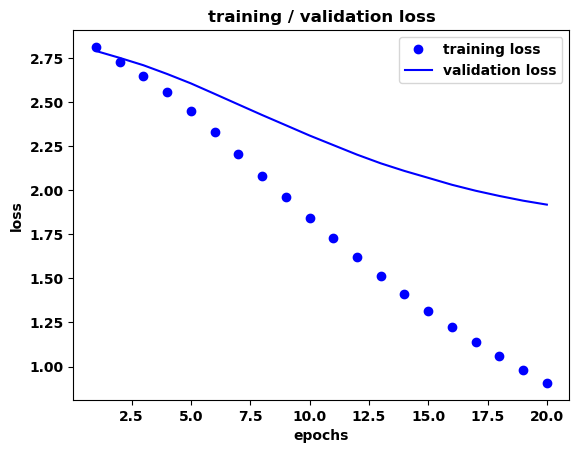

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training / validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

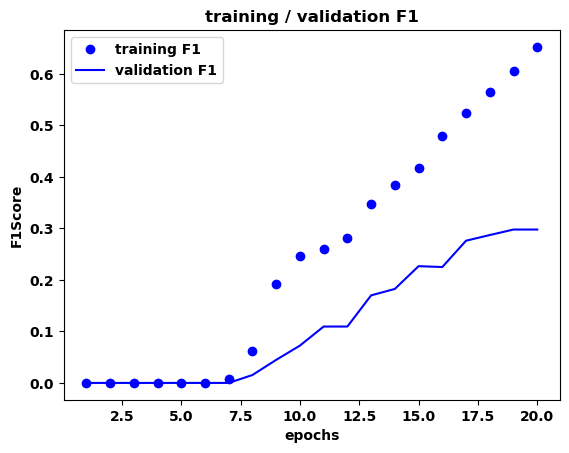

In [15]:
plt.clf()

acc = history.history['custom_f1_score']
val_acc = history.history['val_custom_f1_score']

plt.plot(epochs, acc, 'bo', label='training F1')
plt.plot(epochs, val_acc, 'b', label='validation F1')
plt.title('training / validation F1')
plt.xlabel('epochs')
plt.ylabel('F1Score')
plt.legend()

plt.show()

In [16]:
results = model.evaluate(test_data, test_labels)

2/2 [==============================] - 0s 0s/step - loss: 1.5107 - custom_f1_score: 0.3960


In [17]:
results

[1.5107192993164062, 0.3959827423095703]

The performance of this really simple model is not great, with an F1 score of 49,6 % for the test data. Lets add some parameter testing.

In [18]:
test_plan = {}
test_plan[0] = {"n_units": 32, "n_hidden_layers": 1, "n_epochs": 20, "n_batch_size": 64}
test_plan[1] = {"n_units": 32, "n_hidden_layers": 2, "n_epochs": 20, "n_batch_size": 64}
test_plan[2] = {"n_units": 32, "n_hidden_layers": 3, "n_epochs": 20, "n_batch_size": 64}
test_plan[3] = {"n_units": 64, "n_hidden_layers": 1, "n_epochs": 20, "n_batch_size": 64}
test_plan[4] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 20, "n_batch_size": 64}
test_plan[5] = {"n_units": 64, "n_hidden_layers": 3, "n_epochs": 20, "n_batch_size": 64}
test_plan[6] = {"n_units": 128, "n_hidden_layers": 1, "n_epochs": 20, "n_batch_size": 64}
test_plan[7] = {"n_units": 128, "n_hidden_layers": 2, "n_epochs": 20, "n_batch_size": 64}
test_plan[8] = {"n_units": 128, "n_hidden_layers": 3, "n_epochs": 20, "n_batch_size": 64}
test_plan[9] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 50, "n_batch_size": 64}
test_plan[10] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 100, "n_batch_size": 64}
test_plan[11] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 20, "n_batch_size": 32}
test_plan[12] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 20, "n_batch_size": 16}
test_plan[13] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 20, "n_batch_size": 128}
test_plan[14] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 100, "n_batch_size": 16}
test_plan[15] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 150, "n_batch_size": 16}
test_plan[16] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 200, "n_batch_size": 16}

In [19]:
result_dict = {}

for n in range(len(test_plan)):
    units = test_plan[n]["n_units"]
    hidden_layers = test_plan[n]["n_hidden_layers"]
    n_epochs = test_plan[n]["n_epochs"]
    n_batch_size = test_plan[n]["n_batch_size"]
    
    #initiate model
    model = models.Sequential()
    
    #add hidden layers
    if hidden_layers == 1:
        model.add(layers.Dense(units, activation='relu', input_shape=(1000,)))
    else:
        for i in range(hidden_layers):
            model.add(layers.Dense(units, activation='relu', input_shape=(1000,)))

    # add output layer
    model.add(layers.Dense(17, activation='softmax'))

    #compile model
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[custom_f1_score])

    #fit model
    model.fit(train_data,
              train_labels,
              epochs=n_epochs,
              batch_size=n_batch_size,
              validation_data=(val_data, val_labels))

    results = model.evaluate(test_data, test_labels)
                               
    result_dict[n] = {"activation": "relu/softmax",  
                     "n_units": units, 
                     "n_hidden_layers": hidden_layers, 
                     "n_epochs": n_epochs,
                     "n_batch_size": n_batch_size,
                     "optimizer": "rmsprop", 
                     "loss": "categorical_crossentropy",
                     "F1 Score": results[1]}

Epoch 1/20
5/5 [==============================] - 1s 84ms/step - loss: 2.8147 - custom_f1_score: 0.0000e+00 - val_loss: 2.7956 - val_custom_f1_score: 0.0000e+00
Epoch 2/20
5/5 [==============================] - 0s 14ms/step - loss: 2.7583 - custom_f1_score: 0.0000e+00 - val_loss: 2.7736 - val_custom_f1_score: 0.0000e+00
Epoch 3/20
5/5 [==============================] - 0s 13ms/step - loss: 2.7150 - custom_f1_score: 0.0000e+00 - val_loss: 2.7534 - val_custom_f1_score: 0.0000e+00
Epoch 4/20
5/5 [==============================] - 0s 13ms/step - loss: 2.6733 - custom_f1_score: 0.0000e+00 - val_loss: 2.7325 - val_custom_f1_score: 0.0000e+00
Epoch 5/20
5/5 [==============================] - 0s 14ms/step - loss: 2.6303 - custom_f1_score: 0.0000e+00 - val_loss: 2.7108 - val_custom_f1_score: 0.0000e+00
Epoch 6/20
5/5 [==============================] - 0s 14ms/step - loss: 2.5857 - custom_f1_score: 0.0000e+00 - val_loss: 2.6880 - val_custom_f1_score: 0.0000e+00
Epoch 7/20
5/5 [==================

5/5 [==============================] - 0s 15ms/step - loss: 2.1363 - custom_f1_score: 0.0000e+00 - val_loss: 2.4703 - val_custom_f1_score: 0.0000e+00
Epoch 12/20
5/5 [==============================] - 0s 13ms/step - loss: 2.0535 - custom_f1_score: 0.0133 - val_loss: 2.4364 - val_custom_f1_score: 0.0000e+00
Epoch 13/20
5/5 [==============================] - 0s 14ms/step - loss: 1.9655 - custom_f1_score: 0.0559 - val_loss: 2.4035 - val_custom_f1_score: 0.0000e+00
Epoch 14/20
5/5 [==============================] - 0s 14ms/step - loss: 1.8854 - custom_f1_score: 0.1634 - val_loss: 2.3707 - val_custom_f1_score: 0.0000e+00
Epoch 15/20
5/5 [==============================] - 0s 14ms/step - loss: 1.8035 - custom_f1_score: 0.2066 - val_loss: 2.3460 - val_custom_f1_score: 0.0303
Epoch 16/20
5/5 [==============================] - 0s 14ms/step - loss: 1.7256 - custom_f1_score: 0.2828 - val_loss: 2.3113 - val_custom_f1_score: 0.0818
Epoch 17/20
5/5 [==============================] - 0s 14ms/step - lo

5/5 [==============================] - 1s 89ms/step - loss: 2.8193 - custom_f1_score: 0.0000e+00 - val_loss: 2.8008 - val_custom_f1_score: 0.0000e+00
Epoch 2/20
5/5 [==============================] - 0s 14ms/step - loss: 2.7574 - custom_f1_score: 0.0000e+00 - val_loss: 2.7613 - val_custom_f1_score: 0.0000e+00
Epoch 3/20
5/5 [==============================] - 0s 15ms/step - loss: 2.6800 - custom_f1_score: 0.0000e+00 - val_loss: 2.7107 - val_custom_f1_score: 0.0000e+00
Epoch 4/20
5/5 [==============================] - 0s 14ms/step - loss: 2.5729 - custom_f1_score: 0.0000e+00 - val_loss: 2.6395 - val_custom_f1_score: 0.0000e+00
Epoch 5/20
5/5 [==============================] - 0s 14ms/step - loss: 2.4343 - custom_f1_score: 0.0000e+00 - val_loss: 2.5616 - val_custom_f1_score: 0.0000e+00
Epoch 6/20
5/5 [==============================] - 0s 14ms/step - loss: 2.2792 - custom_f1_score: 0.0068 - val_loss: 2.4837 - val_custom_f1_score: 0.0000e+00
Epoch 7/20
5/5 [==============================] -

5/5 [==============================] - 0s 15ms/step - loss: 1.0148 - custom_f1_score: 0.5819 - val_loss: 1.9110 - val_custom_f1_score: 0.3363
Epoch 13/20
5/5 [==============================] - 0s 14ms/step - loss: 0.8974 - custom_f1_score: 0.6556 - val_loss: 1.8635 - val_custom_f1_score: 0.3613
Epoch 14/20
5/5 [==============================] - 0s 14ms/step - loss: 0.7923 - custom_f1_score: 0.7096 - val_loss: 1.8269 - val_custom_f1_score: 0.3811
Epoch 15/20
5/5 [==============================] - 0s 15ms/step - loss: 0.6985 - custom_f1_score: 0.7607 - val_loss: 1.7975 - val_custom_f1_score: 0.4158
Epoch 16/20
5/5 [==============================] - 0s 15ms/step - loss: 0.6161 - custom_f1_score: 0.7942 - val_loss: 1.7716 - val_custom_f1_score: 0.3953
Epoch 17/20
5/5 [==============================] - 0s 15ms/step - loss: 0.5416 - custom_f1_score: 0.8232 - val_loss: 1.7528 - val_custom_f1_score: 0.4413
Epoch 18/20
5/5 [==============================] - 0s 17ms/step - loss: 0.4769 - custom_

5/5 [==============================] - 0s 14ms/step - loss: 0.7724 - custom_f1_score: 0.7287 - val_loss: 1.9110 - val_custom_f1_score: 0.3518
Epoch 24/50
5/5 [==============================] - 0s 14ms/step - loss: 0.7150 - custom_f1_score: 0.7386 - val_loss: 1.8889 - val_custom_f1_score: 0.3682
Epoch 25/50
5/5 [==============================] - 0s 14ms/step - loss: 0.6579 - custom_f1_score: 0.7614 - val_loss: 1.8792 - val_custom_f1_score: 0.3682
Epoch 26/50
5/5 [==============================] - 0s 14ms/step - loss: 0.6065 - custom_f1_score: 0.7929 - val_loss: 1.8678 - val_custom_f1_score: 0.3835
Epoch 27/50
5/5 [==============================] - 0s 16ms/step - loss: 0.5584 - custom_f1_score: 0.8104 - val_loss: 1.8530 - val_custom_f1_score: 0.4636
Epoch 28/50
5/5 [==============================] - 0s 14ms/step - loss: 0.5174 - custom_f1_score: 0.8454 - val_loss: 1.8418 - val_custom_f1_score: 0.4587
Epoch 29/50
5/5 [==============================] - 0s 14ms/step - loss: 0.4763 - custom_

5/5 [==============================] - 0s 15ms/step - loss: 0.6385 - custom_f1_score: 0.7893 - val_loss: 1.8917 - val_custom_f1_score: 0.3986
Epoch 26/100
5/5 [==============================] - 0s 15ms/step - loss: 0.5893 - custom_f1_score: 0.7998 - val_loss: 1.8831 - val_custom_f1_score: 0.3963
Epoch 27/100
5/5 [==============================] - 0s 14ms/step - loss: 0.5441 - custom_f1_score: 0.8306 - val_loss: 1.8715 - val_custom_f1_score: 0.4272
Epoch 28/100
5/5 [==============================] - 0s 14ms/step - loss: 0.5026 - custom_f1_score: 0.8411 - val_loss: 1.8684 - val_custom_f1_score: 0.4595
Epoch 29/100
5/5 [==============================] - 0s 14ms/step - loss: 0.4605 - custom_f1_score: 0.8633 - val_loss: 1.8641 - val_custom_f1_score: 0.4802
Epoch 30/100
5/5 [==============================] - 0s 14ms/step - loss: 0.4259 - custom_f1_score: 0.8781 - val_loss: 1.8621 - val_custom_f1_score: 0.5046
Epoch 31/100
5/5 [==============================] - 0s 15ms/step - loss: 0.3931 - c

Epoch 78/100
5/5 [==============================] - 0s 15ms/step - loss: 0.0274 - custom_f1_score: 0.9872 - val_loss: 2.7334 - val_custom_f1_score: 0.5956
Epoch 79/100
5/5 [==============================] - 0s 15ms/step - loss: 0.0258 - custom_f1_score: 0.9809 - val_loss: 2.7488 - val_custom_f1_score: 0.5935
Epoch 80/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0259 - custom_f1_score: 0.9841 - val_loss: 2.7743 - val_custom_f1_score: 0.5935
Epoch 81/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0245 - custom_f1_score: 0.9828 - val_loss: 2.7952 - val_custom_f1_score: 0.5935
Epoch 82/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0267 - custom_f1_score: 0.9825 - val_loss: 2.8234 - val_custom_f1_score: 0.5867
Epoch 83/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0250 - custom_f1_score: 0.9837 - val_loss: 2.8535 - val_custom_f1_score: 0.5935
Epoch 84/100
5/5 [==============================] - 0s 14ms/step - los

20/20 [==============================] - 0s 5ms/step - loss: 1.2184 - custom_f1_score: 0.5160 - val_loss: 2.0482 - val_custom_f1_score: 0.3656
Epoch 10/20
20/20 [==============================] - 0s 5ms/step - loss: 1.0737 - custom_f1_score: 0.5906 - val_loss: 2.0161 - val_custom_f1_score: 0.3715
Epoch 11/20
20/20 [==============================] - 0s 5ms/step - loss: 0.9372 - custom_f1_score: 0.6490 - val_loss: 1.9927 - val_custom_f1_score: 0.4267
Epoch 12/20
20/20 [==============================] - 0s 5ms/step - loss: 0.8133 - custom_f1_score: 0.6885 - val_loss: 1.9763 - val_custom_f1_score: 0.4423
Epoch 13/20
20/20 [==============================] - 0s 5ms/step - loss: 0.7026 - custom_f1_score: 0.7462 - val_loss: 1.9656 - val_custom_f1_score: 0.4765
Epoch 14/20
20/20 [==============================] - 0s 5ms/step - loss: 0.6045 - custom_f1_score: 0.8087 - val_loss: 1.9633 - val_custom_f1_score: 0.4659
Epoch 15/20
20/20 [==============================] - 0s 5ms/step - loss: 0.5186 - 

20/20 [==============================] - 0s 5ms/step - loss: 0.2684 - custom_f1_score: 0.9201 - val_loss: 2.0041 - val_custom_f1_score: 0.5435
Epoch 21/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2340 - custom_f1_score: 0.9320 - val_loss: 2.0210 - val_custom_f1_score: 0.5292
Epoch 22/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2056 - custom_f1_score: 0.9436 - val_loss: 2.0484 - val_custom_f1_score: 0.5323
Epoch 23/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1784 - custom_f1_score: 0.9539 - val_loss: 2.1065 - val_custom_f1_score: 0.5405
Epoch 24/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1575 - custom_f1_score: 0.9590 - val_loss: 2.1452 - val_custom_f1_score: 0.5569
Epoch 25/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1413 - custom_f1_score: 0.9608 - val_loss: 2.1709 - val_custom_f1_score: 0.5571
Epoch 26/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1

20/20 [==============================] - 0s 5ms/step - loss: 0.0242 - custom_f1_score: 0.9825 - val_loss: 4.3599 - val_custom_f1_score: 0.5591
Epoch 73/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0263 - custom_f1_score: 0.9781 - val_loss: 4.3990 - val_custom_f1_score: 0.5561
Epoch 74/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0282 - custom_f1_score: 0.9812 - val_loss: 4.4544 - val_custom_f1_score: 0.5532
Epoch 75/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0246 - custom_f1_score: 0.9875 - val_loss: 4.5105 - val_custom_f1_score: 0.5532
Epoch 76/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0285 - custom_f1_score: 0.9812 - val_loss: 4.5515 - val_custom_f1_score: 0.5532
Epoch 77/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0264 - custom_f1_score: 0.9825 - val_loss: 4.5986 - val_custom_f1_score: 0.5505
Epoch 78/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0

Epoch 24/150
20/20 [==============================] - 0s 5ms/step - loss: 0.1354 - custom_f1_score: 0.9575 - val_loss: 2.2058 - val_custom_f1_score: 0.5721
Epoch 25/150
20/20 [==============================] - 0s 5ms/step - loss: 0.1171 - custom_f1_score: 0.9605 - val_loss: 2.2402 - val_custom_f1_score: 0.5698
Epoch 26/150
20/20 [==============================] - 0s 6ms/step - loss: 0.1066 - custom_f1_score: 0.9710 - val_loss: 2.2954 - val_custom_f1_score: 0.5849
Epoch 27/150
20/20 [==============================] - 0s 5ms/step - loss: 0.0897 - custom_f1_score: 0.9746 - val_loss: 2.3971 - val_custom_f1_score: 0.5496
Epoch 28/150
20/20 [==============================] - 0s 5ms/step - loss: 0.0837 - custom_f1_score: 0.9792 - val_loss: 2.3923 - val_custom_f1_score: 0.5808
Epoch 29/150
20/20 [==============================] - 0s 5ms/step - loss: 0.0748 - custom_f1_score: 0.9794 - val_loss: 2.4677 - val_custom_f1_score: 0.5835
Epoch 30/150
20/20 [==============================] - 0s 5ms/ste

20/20 [==============================] - 0s 5ms/step - loss: 0.0279 - custom_f1_score: 0.9812 - val_loss: 4.4671 - val_custom_f1_score: 0.5856
Epoch 77/150
20/20 [==============================] - 0s 5ms/step - loss: 0.0286 - custom_f1_score: 0.9812 - val_loss: 4.5069 - val_custom_f1_score: 0.5911
Epoch 78/150
20/20 [==============================] - 0s 5ms/step - loss: 0.0258 - custom_f1_score: 0.9844 - val_loss: 4.5643 - val_custom_f1_score: 0.5884
Epoch 79/150
20/20 [==============================] - 0s 5ms/step - loss: 0.0280 - custom_f1_score: 0.9856 - val_loss: 4.5760 - val_custom_f1_score: 0.5911
Epoch 80/150
20/20 [==============================] - 0s 5ms/step - loss: 0.0289 - custom_f1_score: 0.9844 - val_loss: 4.5953 - val_custom_f1_score: 0.5859
Epoch 81/150
20/20 [==============================] - 0s 5ms/step - loss: 0.0286 - custom_f1_score: 0.9762 - val_loss: 4.6344 - val_custom_f1_score: 0.5859
Epoch 82/150
20/20 [==============================] - 0s 5ms/step - loss: 0.0

20/20 [==============================] - 0s 5ms/step - loss: 0.0297 - custom_f1_score: 0.9809 - val_loss: 5.7511 - val_custom_f1_score: 0.5477
Epoch 129/150
20/20 [==============================] - 0s 5ms/step - loss: 0.0238 - custom_f1_score: 0.9844 - val_loss: 5.7810 - val_custom_f1_score: 0.5651
Epoch 130/150
20/20 [==============================] - 0s 5ms/step - loss: 0.0279 - custom_f1_score: 0.9825 - val_loss: 5.7786 - val_custom_f1_score: 0.5401
Epoch 131/150
20/20 [==============================] - 0s 5ms/step - loss: 0.0248 - custom_f1_score: 0.9844 - val_loss: 5.7765 - val_custom_f1_score: 0.5425
Epoch 132/150
20/20 [==============================] - 0s 5ms/step - loss: 0.0260 - custom_f1_score: 0.9794 - val_loss: 5.8091 - val_custom_f1_score: 0.5651
Epoch 133/150
20/20 [==============================] - 0s 5ms/step - loss: 0.0252 - custom_f1_score: 0.9844 - val_loss: 5.8110 - val_custom_f1_score: 0.5506
Epoch 134/150
20/20 [==============================] - 0s 5ms/step - los

Epoch 30/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0707 - custom_f1_score: 0.9730 - val_loss: 2.4454 - val_custom_f1_score: 0.5621
Epoch 31/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0641 - custom_f1_score: 0.9795 - val_loss: 2.5161 - val_custom_f1_score: 0.5470
Epoch 32/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0597 - custom_f1_score: 0.9784 - val_loss: 2.5593 - val_custom_f1_score: 0.5525
Epoch 33/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0533 - custom_f1_score: 0.9859 - val_loss: 2.6075 - val_custom_f1_score: 0.5492
Epoch 34/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0490 - custom_f1_score: 0.9780 - val_loss: 2.6479 - val_custom_f1_score: 0.5636
Epoch 35/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0484 - custom_f1_score: 0.9761 - val_loss: 2.7040 - val_custom_f1_score: 0.5496
Epoch 36/200
20/20 [==============================] - 0s 5ms/ste

20/20 [==============================] - 0s 5ms/step - loss: 0.0252 - custom_f1_score: 0.9844 - val_loss: 4.8446 - val_custom_f1_score: 0.5669
Epoch 83/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0286 - custom_f1_score: 0.9812 - val_loss: 4.8700 - val_custom_f1_score: 0.5556
Epoch 84/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0244 - custom_f1_score: 0.9844 - val_loss: 4.9177 - val_custom_f1_score: 0.5577
Epoch 85/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0292 - custom_f1_score: 0.9781 - val_loss: 4.9446 - val_custom_f1_score: 0.5597
Epoch 86/200
20/20 [==============================] - 0s 6ms/step - loss: 0.0257 - custom_f1_score: 0.9809 - val_loss: 4.9695 - val_custom_f1_score: 0.5601
Epoch 87/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0272 - custom_f1_score: 0.9875 - val_loss: 5.0167 - val_custom_f1_score: 0.5597
Epoch 88/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0

20/20 [==============================] - 0s 5ms/step - loss: 0.0263 - custom_f1_score: 0.9781 - val_loss: 6.1571 - val_custom_f1_score: 0.5422
Epoch 135/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0254 - custom_f1_score: 0.9844 - val_loss: 6.1723 - val_custom_f1_score: 0.5422
Epoch 136/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0260 - custom_f1_score: 0.9812 - val_loss: 6.1808 - val_custom_f1_score: 0.5344
Epoch 137/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0270 - custom_f1_score: 0.9781 - val_loss: 6.2113 - val_custom_f1_score: 0.5344
Epoch 138/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0233 - custom_f1_score: 0.9812 - val_loss: 6.2212 - val_custom_f1_score: 0.5422
Epoch 139/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0262 - custom_f1_score: 0.9812 - val_loss: 6.2406 - val_custom_f1_score: 0.5344
Epoch 140/200
20/20 [==============================] - 0s 5ms/step - los

20/20 [==============================] - 0s 5ms/step - loss: 0.0224 - custom_f1_score: 0.9844 - val_loss: 7.0301 - val_custom_f1_score: 0.5499
Epoch 187/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0251 - custom_f1_score: 0.9795 - val_loss: 7.0456 - val_custom_f1_score: 0.5526
Epoch 188/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0239 - custom_f1_score: 0.9812 - val_loss: 7.0634 - val_custom_f1_score: 0.5382
Epoch 189/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0230 - custom_f1_score: 0.9812 - val_loss: 7.0822 - val_custom_f1_score: 0.5556
Epoch 190/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0253 - custom_f1_score: 0.9781 - val_loss: 7.0937 - val_custom_f1_score: 0.5495
Epoch 191/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0243 - custom_f1_score: 0.9794 - val_loss: 7.1006 - val_custom_f1_score: 0.5495
Epoch 192/200
20/20 [==============================] - 0s 5ms/step - los

In [20]:
pd.DataFrame.from_dict(result_dict, orient = "index")

,activation,n_units,n_hidden_layers,n_epochs,n_batch_size,optimizer,loss,F1 Score
0,relu/softmax,32,1,20,64,rmsprop,categorical_crossentropy,0.058824
1,relu/softmax,32,2,20,64,rmsprop,categorical_crossentropy,0.206564
2,relu/softmax,32,3,20,64,rmsprop,categorical_crossentropy,0.387500
3,relu/softmax,64,1,20,64,rmsprop,categorical_crossentropy,0.244444
4,relu/softmax,64,2,20,64,rmsprop,categorical_crossentropy,0.414566
5,relu/softmax,64,3,20,64,rmsprop,categorical_crossentropy,0.491108
6,relu/softmax,128,1,20,64,rmsprop,categorical_crossentropy,0.425595
7,relu/softmax,128,2,20,64,rmsprop,categorical_crossentropy,0.575658
8,relu/softmax,128,3,20,64,rmsprop,categorical_crossentropy,0.649758
9,relu/softmax,64,2,50,64,rmsprop,categorical_crossentropy,0.652038


Using a small batch-size and high number of epochs delivers the best results regarding the F1 Score.

## GloVE Approach

Processing Embeddings

In [21]:
import os
glove_dir = './GitHub/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors' % len(embeddings_index))

Found 400000 word vectors


Now, build an embedding matrix that can be loaded into an `Embedding` layer. It must be a matrix of shape `(max_words,embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index (built during tokenization). Note that the index `0` is not supposed to stand for any word or token. It is simply a placeholder.

In [22]:
max_words = len(word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in the embedding index will be all-zeros
            embedding_matrix[i] = embedding_vector

Building a model

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

maxlen = 1000

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(17, activation='sigmoid'))
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 100)         64100     
                                                                 
 flatten_1 (Flatten)         (None, 100000)            0         
                                                                 
 dense_56 (Dense)            (None, 64)                6400064   
                                                                 
 dense_57 (Dense)            (None, 17)                1105      
                                                                 
Total params: 6,465,269
Trainable params: 6,465,269
Non-trainable params: 0
_________________________________________________________________


loading the embeddings into the model

In [27]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

train model

In [31]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=[custom_f1_score])

history = model.fit(train_data, train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_data, val_labels))

Epoch 1/10
10/10 [==============================] - 2s 85ms/step - loss: 0.1018 - custom_f1_score: 0.9747 - val_loss: 2.4184 - val_custom_f1_score: 0.5983
Epoch 2/10
10/10 [==============================] - 1s 64ms/step - loss: 0.0619 - custom_f1_score: 0.9774 - val_loss: 2.4889 - val_custom_f1_score: 0.5882
Epoch 3/10
10/10 [==============================] - 1s 64ms/step - loss: 0.0483 - custom_f1_score: 0.9813 - val_loss: 2.5342 - val_custom_f1_score: 0.5876
Epoch 4/10
10/10 [==============================] - 0s 39ms/step - loss: 0.0390 - custom_f1_score: 0.9869 - val_loss: 2.5696 - val_custom_f1_score: 0.5846
Epoch 5/10
10/10 [==============================] - 0s 48ms/step - loss: 0.0464 - custom_f1_score: 0.9861 - val_loss: 2.6578 - val_custom_f1_score: 0.5764
Epoch 6/10
10/10 [==============================] - 1s 56ms/step - loss: 0.0424 - custom_f1_score: 0.9854 - val_loss: 2.6968 - val_custom_f1_score: 0.5812
Epoch 7/10
10/10 [==============================] - 1s 54ms/step - los

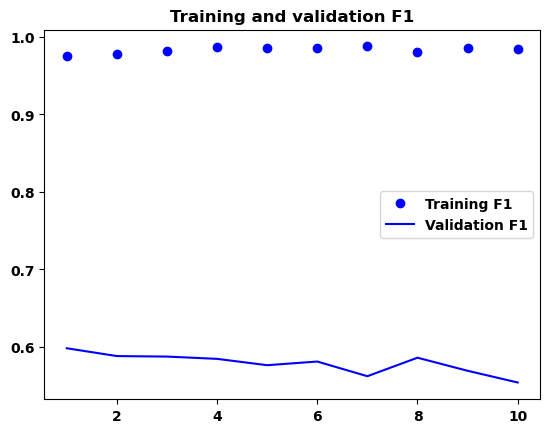

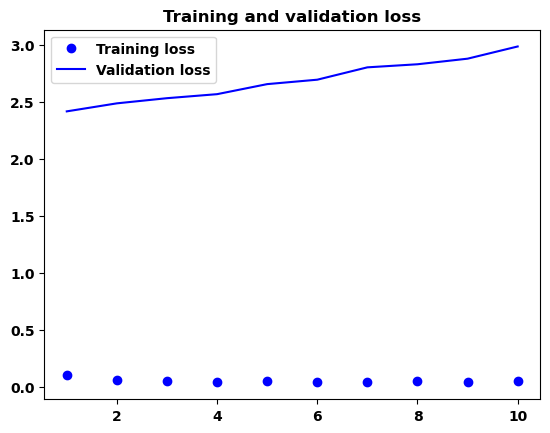

In [35]:
import matplotlib.pyplot as plt

f1 = history.history['custom_f1_score']
val_f1 = history.history['val_custom_f1_score']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, f1, 'bo', label='Training F1')
plt.plot(epochs, val_f1, 'b', label='Validation F1')
plt.title('Training and validation F1')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [36]:
model.evaluate(test_data, test_labels)

2/2 [==============================] - 0s 36ms/step - loss: 1.7475 - custom_f1_score: 0.5943


[1.747499942779541, 0.5942622423171997]

The Glove Approach is performing worse than the previous approach, reaching an accuracy of 59,4 % for the test data.

Next steps in continuing with classyfing the contributions could be:

- Clustering via Embeddings (nearest neighbour)